In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("AQI_part1.ipynb")

# Final Project Part 1: Air Quality Dataset
## Analyzing and Predicting AQI Data through Modeling
## Due Date: Wednesday, November 17th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

## This Assignment

In this final project, we will investigate AQI data for the year 2020 from **USA EPA** data. All the data used for this project can be accessed from the [EPA Website](https://aqs.epa.gov/aqsweb/airdata/download_files.html), which we will pull from directly in this notebook. This dataset contains geographical and time-series data on various factors that contribute to AQI from all government sites. The main goal at the end for you will be to understand how AQI varies both geographically and over time, and use your analysis (as well as other data that you can find) to be predict AQI at a certain point in time for various locations in California.

Through this final project, you will demonstrate your experience with:
* EDA and merging on location using Pandas
* Unsupervised and supervised learning techniques
* Visualization and interpolation

This is **part 1** of the project, which includes the data cleaning, guided EDA and open-ended EDA components of the project. This will help you for part 2, where you will be completing the modeling component. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd

import os
import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

<br/><br/>

---
## Section 1: Data Cleaning

As mentioned, we will be using the **US EPA** data from the EPA website. Below is a dataframe of the files we will be using for the project. The following two cells will download the data and put it into a dictionary called `epa_data`.

In [3]:
epa_weburl = "https://aqs.epa.gov/aqsweb/airdata/"
epa_filenames = pd.read_csv("data/epa_filenames.csv")
epa_filenames

,name,epa_filename
0,annual_county_aqi,annual_aqi_by_county_2020
1,daily_county_aqi,daily_aqi_by_county_2020
2,daily_ozone,daily_44201_2020
3,daily_so2,daily_42401_2020
4,daily_co,daily_42101_2020
5,daily_no2,daily_42602_2020
6,daily_temp,daily_WIND_2020
7,daily_wind,daily_TEMP_2020
8,aqs_sites,aqs_sites


Below is code that we used to extract the code from the AQI website, which we encourage you to understand! This will pull directly from the website urls and put it into your `data/` folder. 

In [4]:
epa_data = {}
for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
    path_name = 'data/{}'.format(name)
    if not os.path.isdir(path_name): 
        data_url = '{}{}.zip'.format(epa_weburl, filename)
        req = requests.get(data_url)
        z = zipfile.ZipFile(io.BytesIO(req.content))
        z.extractall(path_name)
    data = pd.read_csv(f'data/{name}/{filename}.csv')
    epa_data[name] = data

Use the below cell to explore each of the datasets, which can be accessed using the keys in the `name` column of `epa_filenames` above. Currently, the cell is viewing the `annual_county_aqi` dataset, but feel free to change it to whichever dataset you want to explore. 

In [5]:
print(epa_data.keys())

dict_keys(['annual_county_aqi', 'daily_county_aqi', 'daily_ozone', 'daily_so2', 'daily_co', 'daily_no2', 'daily_temp', 'daily_wind', 'aqs_sites'])


In [6]:
epa_data.get('annual_county_aqi').head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
0,Alabama,Baldwin,2020,269,250,19,0,0,0,0,74,49,36,0,0,198,0,71,0
1,Alabama,Clay,2020,108,99,9,0,0,0,0,86,49,26,0,0,0,0,108,0
2,Alabama,DeKalb,2020,364,350,14,0,0,0,0,90,45,36,0,0,331,0,33,0
3,Alabama,Elmore,2020,197,197,0,0,0,0,0,47,41,31,0,0,197,0,0,0
4,Alabama,Etowah,2020,278,260,18,0,0,0,0,92,46,34,0,0,204,0,74,0


<!-- BEGIN QUESTION -->

<br/>

### Question 0: Understanding the Data

Notice that for the table `annual_county_aqi`, the 90th percentile AQI is reported as a column. Why would the 90th percentile AQI be useful as opposed to the maximum? What does it mean when the difference between the 90th percentile AQI and Max AQI is very large compared to the difference between the 90th percentile AQI and the median AQI?

<!--
BEGIN QUESTION
name: q0
manual: True
points: 2
-->

Because sometimes the ouliers could affect model in a large scale, and the outliers would make the distribution right-tailed.

<!-- END QUESTION -->

<br/>

### Question 1a: Creating Month and Day Columns

In the `daily_county_aqi` table in `epa_data`, add two new columns called `Day` and `Month` that denote the day and month, respectively, of the AQI reading. The day and month should both be reported as an **integer** as opposed to a string (`Jan`, `Feb`, etc.)

hint: `pd.to_datetime` may be useful.

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [7]:
epa_data.get('daily_county_aqi')['State Name'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Country Of Mexico', 'Delaware',
       'District Of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'], dtype=object)

In [8]:
daily_county = epa_data.get('daily_county_aqi')
daily_county['Month'] = pd.to_datetime(daily_county['Date']).dt.month
daily_county['Day'] = pd.to_datetime(daily_county['Date']).dt.day


daily_county.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
0,Alabama,Baldwin,1,3,2020-01-01,48,Good,PM2.5,01-003-0010,1,1,1
1,Alabama,Baldwin,1,3,2020-01-04,13,Good,PM2.5,01-003-0010,1,1,4
2,Alabama,Baldwin,1,3,2020-01-07,14,Good,PM2.5,01-003-0010,1,1,7
3,Alabama,Baldwin,1,3,2020-01-10,39,Good,PM2.5,01-003-0010,1,1,10
4,Alabama,Baldwin,1,3,2020-01-13,29,Good,PM2.5,01-003-0010,1,1,13


In [9]:
grader.check("q1a")

q1a results: All test cases passed!

<br/>

### Question 1b: California Data

Currently, `epa_data` contains data for **all** counties in the United States. For the guided part of this project, we are specifically going to be focusing on AQI data for counties in California only. Your task is to assign `epa_data_CA` a dictionary mapping table names to dataframes. This map should have the same contents as `epa_data` but only tables that contain **daily data** in the state of `California`.

<!--
BEGIN QUESTION
name: q1b
points: 3
-->

In [10]:
for val in epa_data.values():
    print(val.columns)

Index(['State', 'County', 'Year', 'Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10'],
      dtype='object')
Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting', 'Month', 'Day'],
      dtype='object')
Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County

In [11]:
epa_data['aqs_sites']

,State Code,County Code,Site Number,Latitude,Longitude,Datum,Elevation,Land Use,Location Setting,Site Established Date,...,Owning Agency,Local Site Name,Address,Zip Code,State Name,County Name,City Name,CBSA Name,Tribe Name,Extraction Date
0,01,1,1,32.437458,-86.472891,WGS84,64.0,RESIDENTIAL,SUBURBAN,1974-05-01,...,Al Dept Of Env Mgt,NaN,"KING ARTHUR TRAILER COURT, PRATTVILLE,AL",36067.0,Alabama,Autauga,Prattville,"Montgomery, AL",NaN,2021-11-24
1,01,1,2,32.428470,-86.443585,WGS84,0.0,AGRICULTURAL,RURAL,1980-01-01,...,Al Dept Of Env Mgt,NaN,COUNTY RD 4 PRATTVILLE EXPERIMENT ST,NaN,Alabama,Autauga,Prattville,"Montgomery, AL",NaN,2021-11-24
2,01,1,3,32.332659,-86.791521,WGS84,41.0,FOREST,RURAL,1989-08-31,...,Al Dept Of Env Mgt,NaN,"1170 COUNTY RD.15 SO., SELMA, AL. 36701",36003.0,Alabama,Autauga,Not in a City,"Montgomery, AL",NaN,2021-11-24
3,01,3,1,0.000000,0.000000,NAD27,0.0,UNKNOWN,RURAL,1959-01-01,...,US EPA National Exposure Research Lab,NaN,CHANDLER RESIDENCE FT MORGAN STATE PARK,NaN,Alabama,Baldwin,Not in a city,"Daphne-Fairhope-Foley, AL",NaN,2021-11-24
4,01,3,2,30.552367,-87.706911,WGS84,0.0,COMMERCIAL,RURAL,1974-01-01,...,Al Dept Of Env Mgt,NaN,COR PENNSYLVANIA & CHICAGO (ROBERTSDALE),36567.0,Alabama,Baldwin,Robertsdale,"Daphne-Fairhope-Foley, AL",NaN,2021-11-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20752,80,26,8012,32.466389,-114.768611,WGS84,38.0,RESIDENTIAL,URBAN AND CENTER CITY,2006-02-01,...,Arizona Department Of Environmental Quality,San Luis Rio Colorado Well 10,Calle 15 & Venustiano Carranza Water Well #10,NaN,Country Of Mexico,SONORA,Not in a City,NaN,NaN,2021-11-24
20753,CC,4,2,44.874774,-66.956190,WGS84,10.0,RESIDENTIAL,RURAL,1995-05-24,...,"Maine D.E.P. Bureau Of Air Quality Control, Au...",NaN,"ROOSEVELT PARK--CAMPOBELLO ISLAND, NB",NaN,Canada,New Brunswick,Not in a City,NaN,NaN,2021-11-24
20754,CC,8,7004,45.004546,-74.703057,WGS84,3.0,COMMERCIAL,RURAL,2002-04-15,...,"St. Regis Mohawk Tribe, New York",C001,"918 ISLAND ROAD, AKWESASNE, ONTARIO CA K6H 5R7",NaN,Canada,Ontario,Not in a city,NaN,"St. Regis Mohawk Tribe, New York",2021-11-24
20755,CC,11,1,49.145602,-103.091252,WGS84,567.0,AGRICULTURAL,RURAL,2000-04-06,...,North Dakota DEQ,NaN,"RAFFERTY DAM, SK",NaN,Canada,Saskatchewan,Not in a city,NaN,NaN,2021-11-24


In [10]:
epa_data_CA = {}
for key,val in epa_data.items():
    if key != 'annual_county_aqi' and key != 'aqs_sites':
        try:
            epa_data_CA[key] = val[val[r'State Name'] == 'California']
        except:
            epa_data_CA[key] = val[val[r'State'] == 'California']
epa_data_CA.get('daily_county_aqi').head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
14197,California,Alameda,6,1,2020-01-01,53,Moderate,PM2.5,06-001-0009,7,1,1
14198,California,Alameda,6,1,2020-01-02,43,Good,PM2.5,06-001-0013,7,1,2
14199,California,Alameda,6,1,2020-01-03,74,Moderate,PM2.5,06-001-0013,7,1,3
14200,California,Alameda,6,1,2020-01-04,45,Good,PM2.5,06-001-0007,7,1,4
14201,California,Alameda,6,1,2020-01-05,33,Good,PM2.5,06-001-0007,7,1,5


In [11]:
grader.check("q1b")

q1b results: All test cases passed!

<br/>

### Question 1c: Merging Site Information

Now take a look at this [link](https://www.epa.gov/outdoor-air-quality-data/about-air-data-reports) and look under "Site ID". For later analysis, we want to first get the latitude and longitudes of each of the measurements in the `daily_county_aqi` table by merging two or more tables in `epa_data_CA` (one of the tables is `daily_county_aqi`).

Our final merged table should be assigned to `epa_data_CA_merged` and the result should contain the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Latitude`, and `Longitude`

<!--
BEGIN QUESTION
name: q1c
points: 4
-->

In [12]:
x = epa_data_CA.get('daily_county_aqi')
x[x['county Name'] == 'Alameda']

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
14197,California,Alameda,6,1,2020-01-01,53,Moderate,PM2.5,06-001-0009,7,1,1
14198,California,Alameda,6,1,2020-01-02,43,Good,PM2.5,06-001-0013,7,1,2
14199,California,Alameda,6,1,2020-01-03,74,Moderate,PM2.5,06-001-0013,7,1,3
14200,California,Alameda,6,1,2020-01-04,45,Good,PM2.5,06-001-0007,7,1,4
14201,California,Alameda,6,1,2020-01-05,33,Good,PM2.5,06-001-0007,7,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
14558,California,Alameda,6,1,2020-12-27,38,Good,PM2.5,06-001-0012,7,12,27
14559,California,Alameda,6,1,2020-12-28,35,Good,PM2.5,06-001-0013,7,12,28
14560,California,Alameda,6,1,2020-12-29,43,Good,PM2.5,06-001-0011,7,12,29
14561,California,Alameda,6,1,2020-12-30,31,Good,PM2.5,06-001-0015,7,12,30


In [13]:
def get_site_id(data):
    site_id = data['Site Num'].astype(str).str.zfill(4)#apply('{0:0>4}'.format)
    sta_id = data['State Code'].astype(str).str.zfill(2)
    cty_id = data['County Code'].astype(str).str.zfill(3)
    data['site id'] = sta_id + '-' + cty_id + '-' + site_id
    #tmp['site id'].head()
    data['Date of Last Change'] = pd.to_datetime(data['Date of Last Change'])
    data= data.sort_values('Date of Last Change',ascending= False).groupby('site id').first().reset_index()
    return data

In [14]:
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']

#d = pd.DataFrame()
#merge_list = epa_data_CA.keys()
#for i in merge_list:
#    if i != 'daily_county_aqi':
#        tmp = epa_data_CA[i].copy()
#        tmp = get_site_id(tmp)
#        d = d.append(tmp[['site id','Latitude','Longitude']])
#d = d.drop_duplicates('site id')

#epa_data_CA_merged = epa_data_CA.get('daily_county_aqi').merge(d,how='left',left_on='Defining Site',right_on='site id')
#epa_data_CA_merged = epa_data_CA_merged[cols]
tmp = epa_data['aqs_sites'].loc[:,["State Code","County Code","Site Number","Latitude","Longitude"]]
tmp['site id'] = tmp['State Code'].str.zfill(2) + '-' + tmp['County Code'].astype(str).str.zfill(3) + '-' + tmp['Site Number'].astype(str).str.zfill(4) 

epa_data_CA_merged = epa_data_CA.get('daily_county_aqi').merge(tmp,how='left',left_on='Defining Site',right_on='site id')
epa_data_CA_merged = epa_data_CA_merged[cols]
del tmp
epa_data_CA_merged[epa_data_CA_merged['Latitude'].isnull()]
#epa_data_CA_merged.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Latitude,Longitude


In [15]:
grader.check("q1c")

q1c results: All test cases passed!

<br/>

### Question 2a - Cleaning Traffic Data 

Throughout this project, you will be using other datasets to assist with analysis and predictions. Traditionally, to join dataframes we need to join on a specific column with shared values. However, when it comes to locations, exact latitudes and longitudes are hard to come by since it is a continuous space. First, lets look at such a dataset that we may want to merge on with `epa_data_CA_merged`. 

In the below cell, we have loaded in the `traffic_data` dataset, which contains traffic data for various locations in California. Your task is to clean this table so that it includes only the following columns (you may have to rename some): `District`, `Route`, `County`, `Descriptn`, `AADT`, `Latitude`, `Longitude`, where `AADT` is found by taking the sum of the back and ahead `AADT`s (you may run into some issues with cleaning the data in order to add these columns - `.str` functions may help with this). The metric AADT, annual average daily traffic, is calculated as the sum of the traffic north of the route (ahead AADT) and south of the route (back AADT). You also need to make sure to clean and remove any illegal values from the dataframe (hint: check `Latitude` and `Longitude`).

*Hint:* `str` functions you will likely use: `.strip()`, `.replace()`.

<!--
BEGIN QUESTION
name: q2a
points: 3
-->

In [16]:
#草稿
tmp = pd.read_csv("data/Traffic_Volumes_AADT.csv")#.info()
back = tmp['Back_AADT'].str.strip().apply(lambda x: int(x) if x != '' else 0)
ahead = tmp['Ahead_AADT'].str.strip().apply(lambda x: int(x) if x != '' else 0)
tmp

,OBJECTID_1,OBJECTID,District,Route,Rte_SFX,County,PM_PFX,Postmile,PM_SFX,Descriptn,Back_pk_h,Back_pk_m,Back_AADT,Ahead_pk_h,Ahead_pk_m,Ahead_AADT,Lon_S_or_W,Lat_S_or_W,Lon_N_or_E,Lat_N_or_E
0,1,1,1,1,,MEN,,0.000,,SONOMA/MENDOCINO COUNTY LINE,,,,440,4650,4000,-123.5185026,38.75984264,-123.5185026,38.75984264
1,2,2,1,1,,MEN,,1.020,,NORTH LIMITS GUALALA,440,4650,4000,370,3700,3100,-123.53189,38.77004592,-123.53189,38.77004592
2,3,3,1,1,,MEN,,5.090,,FISH ROCK ROAD,320,3600,3100,210,2600,3100,-123.585411,38.80354931,-123.585411,38.80354931
3,4,4,1,1,,MEN,,14.692,,"POINT ARENA, SOUTH CITY LIMITS",240,2600,2200,240,2850,2400,-123.6915134,38.90397338,-123.6915134,38.90397338
4,5,5,1,1,,MEN,,15.180,,"POINT ARENA, RIVERSIDE DRIVE",250,2800,2400,250,2800,2600,-123.6924099,38.91091252,-123.6924099,38.91091252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7115,7116,7116,12,605,,ORA,,3.092,,"SEAL BEACH, JCT RTE 22",,,,3250,47000,46100,-118.0914735,33.7786335,-118.0908233,33.77861286
7116,7117,7117,12,605,,ORA,R,0.000,,JCT. RTE. 405,3250,47000,44700,11700,172000,167500,-118.0917676,33.78441396,-118.09138,33.78396418
7117,7118,7118,12,605,,ORA,R,1.405,,"LOS ALAMITOS, KATELLA AVENUE",11600,169000,159800,14100,173000,167000,-118.0820302,33.80279867,-118.0817329,33.80281106
7118,7119,7119,12,605,,ORA,R,1.643,,ORANGE/LOS ANGELES COUNTY LINE,14800,177000,170000,,,,-118.081547,33.80613969,-118.081287,33.8063525


In [17]:
switch_index =  tmp[tmp['Lon_S_or_W'].str.match('-*\d+\.\d+')==False].index 
tmp.loc[switch_index,'Lon_S_or_W'] = tmp.loc[switch_index,'Lon_N_or_E']
tmp.loc[switch_index,'Lat_S_or_W'] = tmp.loc[switch_index,'Lat_N_or_E']
del tmp

In [18]:
cols = ['District','Route','County','Descriptn','Back_AADT','Ahead_AADT']
traffic_data = pd.read_csv("data/Traffic_Volumes_AADT.csv")
tmp = traffic_data.copy()
back = tmp['Back_AADT'].str.strip().apply(lambda x: int(x) if x != '' else 0)
ahead = tmp['Ahead_AADT'].str.strip().apply(lambda x: int(x) if x != '' else 0)
tmp['AADT'] = back + ahead
switch_index =  tmp[tmp['Lon_S_or_W'].str.match('-*\d+\.\d+')==False].index 
tmp.loc[switch_index,'Lon_S_or_W'] = tmp.loc[switch_index,'Lon_N_or_E']
tmp.loc[switch_index,'Lat_S_or_W'] = tmp.loc[switch_index,'Lat_N_or_E']
traffic_data_cleaned = tmp[['District','Route','County','Descriptn','AADT','Lon_S_or_W','Lat_S_or_W']]    \
                        .rename(columns={'Lon_S_or_W':'Longitude',
                                        'Lat_S_or_W':'Latitude'})
del tmp
traffic_data_cleaned['Longitude'] = traffic_data_cleaned['Longitude'].astype(float)
traffic_data_cleaned['Latitude'] = traffic_data_cleaned['Latitude'].astype(float)
traffic_data_cleaned.head()

,District,Route,County,Descriptn,AADT,Longitude,Latitude
0,1,1,MEN,SONOMA/MENDOCINO COUNTY LINE,4000,-123.518503,38.759843
1,1,1,MEN,NORTH LIMITS GUALALA,7100,-123.531890,38.770046
2,1,1,MEN,FISH ROCK ROAD,6200,-123.585411,38.803549
3,1,1,MEN,"POINT ARENA, SOUTH CITY LIMITS",4600,-123.691513,38.903973
4,1,1,MEN,"POINT ARENA, RIVERSIDE DRIVE",5000,-123.692410,38.910913


In [19]:
grader.check("q2a")

q2a results: All test cases passed!

### Question 2b - Merging on Traffic Data 

Traditionally, we could employ some sort of join where we join `epa_data_CA_merged` rows with the row in `traffic_data` that it is the "closest" to, as measured by euclidean distance. As you can imagine, this can be quite tedious so instead we will use a special type of join called a **spatial join**, which can be done using the package `geopandas`, which is imported as `gpd`. The documentation for `geopandas` is linked [here](https://geopandas.org/docs/reference/api/geopandas.sjoin_nearest.html). Please use this as a resource to do the following tasks: 

 - turn `traffic_data_cleaned` and `epa_data_CA_merged` into a geopandas dataframe using the latitude and longitude.
 - Use a spatial join (which function is this in the documentation?) to match the correct traffic row information to each entry in `epa_data_CA_merged`. 

Your final dataframe should be assigned to `gpd_epa_traffic` with the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Site Lat`, `Site Long`, `Traffic Lat`, `Traffic Long`, `Descriptn`, and `AADT`.

<!--
BEGIN QUESTION
name: q2b
points: 2
-->

In [22]:
epa_data_CA_merged_gpd

NameError: name 'epa_data_CA_merged_gpd' is not defined

In [ ]:
traffic_data_cleaned_gpd['geometry']

In [20]:
traffic_data_cleaned_gpd = gpd.GeoDataFrame(traffic_data_cleaned,
            geometry=gpd.points_from_xy(traffic_data_cleaned.Longitude, traffic_data_cleaned.Latitude))
epa_data_CA_merged_gpd = gpd.GeoDataFrame(epa_data_CA_merged,
            geometry=gpd.points_from_xy(epa_data_CA_merged.Longitude,epa_data_CA_merged.Latitude))

#epa_data_CA_merged_gpd.sjoin_nearest(traffic_data_cleaned_gpd)
gpd_epa_traffic = gpd.sjoin_nearest(epa_data_CA_merged_gpd,traffic_data_cleaned_gpd)
#gpd_epa_traffic['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude_left', 'Longitude_left', `Traffic Lat`, `Traffic Long`, `Descriptn`, and `AADT`]
#gpd_epa_traffic.head()

AttributeError: module 'geopandas' has no attribute 'sjoin_nearest'

In [ ]:
traffic_data_cleaned_gpd

<AxesSubplot:>

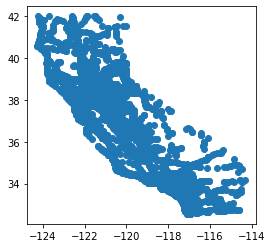

In [ ]:
traffic_data_cleaned_gpd['geometry'].plot()

<AxesSubplot:>

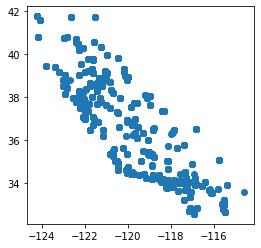

In [ ]:
epa_data_CA_merged_gpd['geometry'].plot()

In [ ]:
grader.check("q2b")

NameError: name 'grader' is not defined

<br/><br/>

---
## Section 2: Guided EDA


### Question 3a: Initial AQI Analysis

Assign a `pd.Series` object to `worst_median_aqis` that contains the states with the top 10 worst median AQIs throughout the year 2020, as measured by the average median AQIs across all counties for a single state. Your result should have index `state`, the column value should be labelled `Average Median AQI`, and it should be arranged in descending order.

Now, assign the same thing to `worst_max_aqis`, except instead of aggregating the average median AQIs across all counties, aggregate the average **max AQIs** across all counties. Your result should have the same shape and labels as before, except the column value should be labelled `Average Max AQI`. 

Note: you may have to remove a few regions in your tables. Make sure every entry in your output is a **US State**.

<!--
BEGIN QUESTION
name: q3a
points: 2
-->

In [39]:
epa_data.get('annual_county_aqi').head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
0,Alabama,Baldwin,2020,269,250,19,0,0,0,0,74,49,36,0,0,198,0,71,0
1,Alabama,Clay,2020,108,99,9,0,0,0,0,86,49,26,0,0,0,0,108,0
2,Alabama,DeKalb,2020,364,350,14,0,0,0,0,90,45,36,0,0,331,0,33,0
3,Alabama,Elmore,2020,197,197,0,0,0,0,0,47,41,31,0,0,197,0,0,0
4,Alabama,Etowah,2020,278,260,18,0,0,0,0,92,46,34,0,0,204,0,74,0


In [21]:
tmp1 = epa_data.get('annual_county_aqi').groupby('State')['Median AQI'].mean().reset_index().sort_values('Median AQI',ascending=False).rename(columns={'Median AQI':'worst_median_aqis'})
#np.round(tmp1['Median AQI'],2)
tmp2 = epa_data.get('annual_county_aqi').groupby('State')['Max AQI'].mean().reset_index().sort_values('Max AQI',ascending=False).rename(columns={'Max AQI':'worst_max_aqis'})


In [ ]:
tmp1.head(10)

In [ ]:
tmp2.head(10)

In [ ]:
worst_median_aqis = tmp1
worst_max_aqis = tmp2


print("Worst Median AQI : \n{}\n".format(worst_median_aqis))
print("Worst Max AQI : \n{}".format(worst_max_aqis))

np.round(list(worst_max_aqis), 2)

In [ ]:
grader.check("q3a")

<!-- BEGIN QUESTION -->

<br/>

### Question 3b: Worst AQI States

What are the states that are in both of the top 10 lists? Why do you think most of these states are on both of the lists?

<!--
BEGIN QUESTION
name: q3b
manual: True
points: 2
-->

<!-- END QUESTION -->

<br/>

### Question 4a: Missing AQI Data

We want to see the accessibility of the AQI data across states. In the following cell, assign `days_with_AQI` to a series that contains the state as the index and the average number of days with AQI entries across all counties in that state as the value. Make sure to label the series as `Days with AQI` and sort in ascending order (smallest average number of days at the top). As before, make sure to remove the regions that are not **US States** from your series.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [ ]:
epa_data.get('annual_county_aqi').groupby('State')['Days with AQI'].mean().sort_values(ascending=True).reset_index()

In [31]:
days_with_AQI = epa_data.get('annual_county_aqi').groupby('State')['Days with AQI'].mean().sort_values(ascending=True)

days_with_AQI.head(10)

State
Virgin Islands        76.000000
Country Of Mexico    119.000000
Puerto Rico          216.181818
Arkansas             251.636364
Alaska               252.222222
Virginia             265.363636
New Mexico           279.375000
Colorado             287.321429
Nebraska             288.222222
Iowa                 289.187500
Name: Days with AQI, dtype: float64

In [29]:
grader.check("q4a")

q4a results:
    q4a - 1 result:
        Trying:
            np.all(np.round(list(days_with_AQI.head()), 2) == np.array([235.22, 251.55, 264.06, 265.3 , 278.89]))
        Expecting:
            True
        **********************************************************************
        Line 1, in q4a 0
        Failed example:
            np.all(np.round(list(days_with_AQI.head()), 2) == np.array([235.22, 251.55, 264.06, 265.3 , 278.89]))
        Exception raised:
            Traceback (most recent call last):
              File "/home/frank/miniconda3/envs/data100/lib/python3.6/doctest.py", line 1330, in __run
                compileflags, 1), test.globs)
              File "<doctest q4a 0[0]>", line 1, in <module>
                np.all(np.round(list(days_with_AQI.head()), 2) == np.array([235.22, 251.55, 264.06, 265.3 , 278.89]))
              File "<__array_function__ internals>", line 6, in round_
              File "/home/frank/miniconda3/envs/data100/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 3637, in round_
                return around(a, decimals=decimals, out=out)
              File "<__array_function__ internals>", line 6, in around
              File "/home/frank/miniconda3/envs/data100/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 3262, in around
                return _wrapfunc(a, 'round', decimals=decimals, out=out)
              File "/home/frank/miniconda3/envs/data100/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 55, in _wrapfunc
                return _wrapit(obj, method, *args, **kwds)
              File "/home/frank/miniconda3/envs/data100/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 44, in _wrapit
                result = getattr(asarray(obj), method)(*args, **kwds)
            numpy.core._exceptions._UFuncNoLoopError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

<br/>

### Question 4b: What are the missing dates?

In the following cell, we create the series `ca_aqi_days` that outputs a series with each county in California mapped to the number of days that they have AQI data on. Notice that there exists a few counties without the full year of data, which is what you will be taking a closer look at in the following two parts.

In [34]:
ca_annual_data = epa_data.get('annual_county_aqi')[epa_data.get('annual_county_aqi')['State'] == 'California']
ca_aqi_days = ca_annual_data['Days with AQI'].sort_values()
ca_aqi_days.head(10)

54    291
96    342
63    351
98    353
49    359
76    360
51    364
57    364
72    365
79    366
Name: Days with AQI, dtype: int64

#### Question 4bi: Missing Days

Assign `county_to_missing_dates` to a dictionary that maps each county with less than the full year of data to the dates that have missing AQI data. Make sure that your keys are just the county name (no whitespace around it or `, California` appended to it) and the values are of the format `yyyy-mm-dd`.

<!--
BEGIN QUESTION
name: q4i
points: 2
-->

In [76]:
missing_name = ca_annual_data[ca_annual_data['Days with AQI'] < 366].County.tolist()
daily_aqi_ca = epa_data_CA['daily_county_aqi']
def get_date(x):
    return pd.to_datetime(x['Date']).dt.strftime('%Y-%m-%d').tolist()

dic_exist=daily_aqi_ca.loc[daily_aqi_ca['county Name'].isin(missing_name)].groupby('county Name').apply(get_date).to_dict()
all_year = pd.date_range(start='20200101',end='20201231',freq='D').strftime('%Y-%m-%d').tolist()
dic_nonexist = { key: set(all_year) - set(val) for key,val in dic_exist.items()}
county_to_missing_dates = { key: list(set(all_year) - set(val)) for key,val in dic_exist.items()}


In [ ]:
#Other solution(maybe better)
tmp = pd.to_datetime(daily_aqi_ca.loc[daily_aqi_ca['county Name']=='Del Norte','Date'])
pd.date_range(start='20200101',end='20201231',freq='D').difference(tmp).to_list()


In [78]:
grader.check("q4i")

q4i results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 4bii: Missing Days

Are there any key missing dates in common between the counties that have missing AQI data? What two counties have the most missing days and why do you think they do?

<!--
BEGIN QUESTION
name: q4bii
manual: True
points: 2
-->

In [88]:
# Trinity and Del Morte have the most missing day
sorted(county_to_missing_dates.keys(), key=lambda x: len(county_to_missing_dates[x]))

['Napa',
 'Calaveras',
 'Glenn',
 'Plumas',
 'Amador',
 'Tuolumne',
 'Lake',
 'Trinity',
 'Del Norte']

In [ ]:
county_to_missing_dates

_Type your answer here, replacing this text._

<!-- END QUESTION -->



<br/>

### Question 5a: AQI over Time 

Assign `aqi_per_month` to a series of the average aqi per month across all US states and `aqi_per_month_CA` to a series of the average AQI per month across California.

<!--
BEGIN QUESTION
name: q5a
points: 1
-->

In [ ]:
epa_data['daily_county_aqi']

In [99]:
aqi_per_month_CA = daily_aqi_ca.copy()
aqi_per_month_CA['Date'] = pd.to_datetime(aqi_per_month_CA['Date'])
taqi_per_month_CAmp = aqi_per_month_CA.set_index('Date').resample('M').agg({'AQI':'mean'})
aqi_per_month_CA

,AQI
Date,
2020-01-31,46.346888
2020-02-29,47.110236
2020-03-31,40.114094
2020-04-30,41.443462
2020-05-31,49.538319
2020-06-30,47.849936
2020-07-31,55.731269
2020-08-31,80.107579
2020-09-30,107.289773


In [ ]:
tmp = tmp.set_index('Date').resample

In [108]:
aqi_per_month = epa_data['daily_county_aqi'].copy()
aqi_per_month['Date'] = pd.to_datetime(aqi_per_month['Date'])
aqi_per_month = aqi_per_month.set_index('Date').resample('M')['AQI'].mean()

aqi_per_month_CA = daily_aqi_ca.copy()
aqi_per_month_CA['Date'] = pd.to_datetime(aqi_per_month_CA['Date'])
aqi_per_month_CA = aqi_per_month_CA.set_index('Date').resample('M')['AQI'].mean()
#aqi_per_month_CA


print("AQI per Month: \n{}\n".format(aqi_per_month))
print("AQI per Month California : \n{}".format(aqi_per_month_CA))

AQI per Month: 
Date
2020-01-31    31.033175
2020-02-29    32.258979
2020-03-31    34.509350
2020-04-30    37.287264
2020-05-31    36.272962
2020-06-30    40.333542
2020-07-31    39.869549
2020-08-31    41.105009
2020-09-30    43.153464
2020-10-31    35.160379
2020-11-30    34.187417
2020-12-31    34.996066
Freq: M, Name: AQI, dtype: float64

AQI per Month California : 
Date
2020-01-31     46.346888
2020-02-29     47.110236
2020-03-31     40.114094
2020-04-30     41.443462
2020-05-31     49.538319
2020-06-30     47.849936
2020-07-31     55.731269
2020-08-31     80.107579
2020-09-30    107.289773
2020-10-31     75.832825
2020-11-30     52.070573
2020-12-31     53.694936
Freq: M, Name: AQI, dtype: float64


In [109]:
np.round(list(aqi_per_month_CA), 2)

array([ 46.35,  47.11,  40.11,  41.44,  49.54,  47.85,  55.73,  80.11,
       107.29,  75.83,  52.07,  53.69])

In [ ]:
grader.check("q5a")

<!-- BEGIN QUESTION -->

<br/>

### Question 5b: AQI over Time Analysis 

Is there anything interesting that you notice in `aqi_per_month_CA`? If so, why do you think that is?

<!--
BEGIN QUESTION
name: q5b
manual: True
points: 1
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 5c: Modeling AQI over Time

Based on the AQI pattern in the year 2020, if we were to model AQI over the last 10 years, with the average AQI per year being the same, what sort of parametric function $f(x)$ would you use? Let us say that we see a linear increase in the average AQI per year over the last 10 years instead, then what parametric function $g(x)$ would you use?

<!--
BEGIN QUESTION
name: q5c
manual: True
points: 3
-->

1. y = $theta$ * x 
2. $log(y)$ =  $theta$ * x 

<!-- END QUESTION -->



<br/>

### Question 6a: Create Heatmap Buckets

Now we want to create a function called `bucket_data`, which takes in the following parameters: `table`, `resolution`. It outputs a pivot table with the latitude bucket (smallest latitude for that grid point) on the index and the longitude bucket (smallest longitude for that grid point) on the columns. The values in the pivot table should be the average AQI of the monitor sites inside that respective rectangle grid of latitudes and longitudes. The following should be the output of `bucket_data(epa_data_CA_merged, np.mean, 5)`:

<img src="images/q6a.png" width="600px" align="center"/>

The `resolution` parameter describes the number of buckets that the latitudes and longitudes are divided into on the heatmap. As an example, let us say that the range of longitudes for site monitors are between \[100, 110\]; make sure that the start of the range is exactly the **minimum** of all longitude values of your site monitors and the end of the range is the exactly the **maximum** of all longitude values of your site monitors. Let us say that we have a resolution of 10. Then we have the buckets 
$$([100, 101], [101, 102], ..., [109, 110])$$

The column and row labels of this dataframe should be labelled as the **start** of the bucket. In the case of the example above, the names of the buckets should be $ 100, 101, \dots 109 $. Note that we are just looking at the longitude dimension in this example, and you have to do do the same for the latitude dimension along the rows in order to build the pivot table.

Finally, make sure the row and column labels of your pivot table are **exactly** the same as the example given above. 
<!--
BEGIN QUESTION
name: q6a
points: 6
-->

In [ ]:
epa_data_CA_merged#[['Latitude','Longitude']].describe()

In [132]:
t = pd.cut(epa_data_CA_merged['Latitude'],5)
t.map(lambda x: x.left)

0        36.249
1        36.249
2        36.249
3        36.249
4        36.249
          ...  
19248    38.085
19249    38.085
19250    38.085
19251    38.085
19252    38.085
Name: Latitude, Length: 19253, dtype: category
Categories (5, float64): [32.569 < 34.414 < 36.249 < 38.085 < 39.921]

In [135]:
def bucket_data(table, aggfunc, resolution):
    lat = pd.cut(table['Latitude'],resolution)
    lat = lat.map(lambda x: x.left)
    long = pd.cut(table['Longitude'],resolution)
    long = long.map(lambda x: x.left)
    data = table.copy()
    data['lat_bucket'] = lat
    data['long_bucket'] = long
    return pd.pivot_table(data, values='AQI',index='lat_bucket',columns='long_bucket',aggfunc=aggfunc)
bucket_data(epa_data_CA_merged, np.mean, 5)

long_bucket,-124.213,-122.283,-120.363,-118.443,-116.522
lat_bucket,,,,,
32.569,NaN,NaN,65.317391,87.007624,67.955508
34.414,NaN,50.223427,67.865521,74.281553,58.294118
36.249,42.877919,51.514615,81.436208,74.704918,NaN
38.085,39.009050,53.662435,50.543103,NaN,NaN
39.921,38.410941,55.717050,NaN,NaN,NaN


In [ ]:
grader.check("q6a")

<br/>

### Question 6b: Visualize Heatmap

Assign `heatmap_data` to a heatmap bucket pivot table aggregated by median with resolution 30 for California AQI for the month of september. The code in the following cell will plot this heatmap for you. 

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [ ]:
bucket_data(epa_data_CA_merged[epa_data_CA_merged['Month']==9],np.median,30)

In [138]:
heatmap_data = bucket_data(epa_data_CA_merged[epa_data_CA_merged['Month']==9],np.median,30)


#create visualization
plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

<Figure size 1080x576 with 0 Axes>

In [ ]:
grader.check("q6b")

<!-- BEGIN QUESTION -->

<br/>

### Question 6c: Analyze Heatmap

Look up where the dark regions correspond to. Does this heatmap make sense?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



<br/><br/>

---
## Part 3: Open-Ended EDA

Not that we have explored the data both spatially and temporally, we want to be able to look at what other indicators there are for air quality in California. Through the previous few questions we have discussed that wilfire data as well as temperature may be good indicators, but we can explitly look at correlations via the temperature to verify our hypothesis. Like temperature, there are other columns of data such as particulate matter, chemical concentrations, wind data, etc. Your open-ended EDA will be useful for filling in missing points in the heatmap that you created in question 4b. 

Your goal in this question is to find relationships between AQI and other features in the current datasets, across time and space. Your exploration can include, but is not limited to: 
- Looking at correlations between AQI and various columns of interest in `epa_data_CA`.
    - This will require some merging, which you can look at question 1 for reference. 
- Performing clustering and/or other unsupervised learning methods such as PCA to discover clusters or useful (combinations of) features in the data.
- Merging and exploring other external datasets that you may think are useful.

<!-- BEGIN QUESTION -->

### Question 7a - Code and Analysis

Please complete all of your analysis in the **single cell** below based on the prompt above.

<!--
BEGIN QUESTION
name: q7a
manual: True
points: 10
-->

In [ ]:
epa_data.get('annual_county_aqi').head()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7b - Visualization

Please create **two** visualizations to summarize your analysis above. The only restrictions are that these visualizations **cannot** simply be scatterplots between two features in the dataset(s) and **cannot** be of the same type (dont make two bar graphs, for example). 

<!--
BEGIN QUESTION
name: q7b
manual: True
points: 4
-->

In [ ]:
#plt.scatter(...)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7c - Summary

In a paragraph, summarize the your findings and visualizations and explain how they will be useful for predicting AQI. Make sure that your answer is thoughtful and detailed in that it describes what you did and how you reached your conclusion. 

<!--
BEGIN QUESTION
name: q7c
manual: True
points: 4
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()